In [2]:
import numpy
import matplotlib.pyplot as plt


95
8.819457658885785
train lr
train flow
[4, 0.5]
[3, 0.9900990099009901]
3.0867684161059237
2.2602426680471726


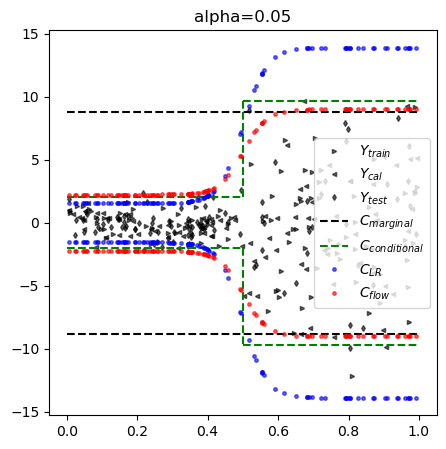

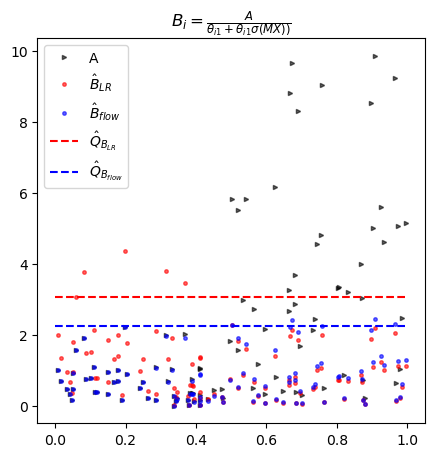

In [212]:
N = 100
cut = 1/2
scale = 5
EPSLR= .5
EPS = .01
Msmooth = 30
data=[]
for i in [0, 1, 2]:
    X = numpy.random.rand(N)
    Y = [numpy.random.randn() * (x<cut) + scale * numpy.random.randn() * (x>cut) for x in X]
    data.append([X, Y])

train, cal, test = data
alpha = .05
m = int(numpy.ceil((1-alpha) * len(cal[1])))
print(m)
q = numpy.sort([abs(s) for s in cal[1]])[m]
print(q)

lowsamples = [cal[1][i] for i in range(len(cal[1])) if cal[0][i] < cut]
mlow = int(numpy.ceil((1-alpha) * len(lowsamples)))
qlow = numpy.sort([abs(s) for s in lowsamples])[mlow]

highsamples = [cal[1][i] for i in range(len(cal[1])) if cal[0][i] > cut]
mhigh = int(numpy.ceil((1-alpha) * len(highsamples)))
qhigh = numpy.sort([abs(s) for s in highsamples])[mhigh]

def sigmoid(t, M = Msmooth):
    return 1/(1 + numpy.exp(- M * t))

def phiSmooth(A, X, theta, eps=EPS):
    L, C = theta
    g = L * sigmoid(X - 1/2)
    B = A/(EPS + C + g)
    return B


def jacobianPhiSmooth(A, X, theta, eps=EPS):
    L, C = theta
    g = L * sigmoid(X - 1/2)
    J = 1/(EPS + C + g)
    return J

def inversePhiSmooth(B, X, theta, eps=EPS):
    L, C = theta
    g = L * sigmoid(X - 1/2) 
    A = B * (EPS + C + g)
    return B

tryL = range(10)
tryC = [1/(EPS + s) for s in range(20)]
grid = [tryL, tryC]

def LR(A, X, theta):
    L, C = theta
    g = [L * sigmoid(X[i] - 1/2) for i in range(len(X))]
    return numpy.mean([numpy.power(A[i]*A[i] - g[i]*g[i], 2) for i in range(len(A))])

def flow(A, X, theta, eps=EPS):
    B = [phiSmooth(A[i], X[i], theta) for i in range(len(A))]
    J = [jacobianPhiSmooth(A[i], X[i], theta) for i in range(len(A))]
    #s = - numpy.log(.000001 + 1.* (B<1)) - numpy.log(J)
    #print(min(s), max(s))
    s = [numpy.power(B[i], 2)/2 - numpy.log(J[i]) for i in range(len(B))]
    return numpy.mean(s)

def errorFit(train, grid, obj):
    tryL, tryC = grid
    A = [abs(s) for s in train[1]]
    X = train[0]
    best = 1e+16
    for L in tryL:
        for C in tryC:
            theta = L, C
            ell = obj(A, X, theta)
            if ell < best:
                best = ell
                bestL, bestC = [L, C]
    return [bestL, bestC]
                
            
print("train lr")
thetaLR = errorFit(train, grid, LR)
thetaLR = [thetaLR[0], EPSLR]
BLR = [phiSmooth(abs(cal[1][i]), cal[0][i], thetaLR) for i in range(len(cal[1]))]
print("train flow")
thetaFlow = errorFit(train, grid, flow)
BFlow = [phiSmooth(abs(cal[1][i]), cal[0][i], thetaFlow) for i in range(len(cal[1]))]
print(thetaLR)
print(thetaFlow)

m = int(numpy.ceil((1-alpha) * len(cal[1])))
qLR = numpy.sort(BLR)[m]
qFlow = numpy.sort(BFlow)[m]
print(qLR)
print(qFlow)


gapsLR = []
gapsFlow = []
tryX = [s/(N-1) for s in range(N)]
tryX = [s for s in test[0]]
for x in tryX:
    L, C = thetaLR
    s = qLR * (C + L * sigmoid(x - 1/2))
    gapsLR.append(s)#
    L, C = thetaFlow
    s = qFlow * (C + L * sigmoid(x - 1/2))
    gapsFlow.append(s)
#plot
ms=3
a = .6
ms2=5
a2=.6
plt.figure(figsize=(5, 5))
plt.plot(train[0], train[1], '>k', markersize=ms, alpha=a, label='$Y_{train}$')
plt.plot(cal[0], cal[1], '<k', markersize=ms, alpha=a, label='$Y_{cal}$')
plt.plot(test[0], test[1], 'dk', markersize=ms, alpha=a, label='$Y_{test}$')

plt.plot([0, 1], [q, q], '--k', label='$C_{marginal}$')
plt.plot([0, 1], [-q, -q], '--k')

plt.plot([0, cut], [qlow, qlow], '--g', label='$C_{conditional}$')
plt.plot([cut, cut], [qlow, qhigh], '--g')
plt.plot([0, cut], [-qlow, -qlow], '--g')

plt.plot([cut, 1], [qhigh, qhigh], '--g')
plt.plot([cut, cut], [-qlow, -qhigh], '--g')
plt.plot([cut, 1], [-qhigh, -qhigh], '--g')


plt.plot(tryX, gapsLR, 'b.', markersize=ms2, alpha=a2,label='$C_{LR}$')
plt.plot(tryX, gapsFlow, 'r.', markersize=ms2, alpha=a2,label='$C_{flow}$')
plt.plot(tryX, [-s for s in gapsLR],'b.',markersize=ms2, alpha=a2)
plt.plot(tryX, [-s for s in gapsFlow], 'r.',markersize=ms2, alpha=a2)


plt.title('alpha='+str(alpha))
plt.legend()
dirPlots = 'toymodel/'
fileName = dirPlots + 'toyModel.pdf'
plt.savefig(fileName)
plt.show()


plt.figure(figsize=(5, 5))

plt.plot(cal[0], [abs(s) for s in cal[1]], '>k', markersize=ms, alpha=a, label='A')
plt.plot(cal[0], BLR, 'r.', markersize=ms2, alpha=a2, label='$\hat B_{LR}$')
plt.plot(cal[0], BFlow, 'b.', markersize=ms2, alpha=a2, label = '$\hat B_{flow}$')
plt.plot([0, 1], [qLR, qLR], '--r', label='$\hat Q_{B_{LR}}$')
plt.plot([0, 1], [qFlow, qFlow], '--b', label='$\hat Q_{B_{flow}}$')

plt.title('$B_i= \\frac{A}{\\theta_{i1} + \\theta_{i1} \\sigma(MX))}$')
plt.legend()
dirPlots = 'toymodel/'
fileName = dirPlots + 'bSamples.pdf'
plt.savefig(fileName)
plt.show()

